## Packages

In [2]:
import json
import pandas as pd
import os
import sys
import requests

print(sys.executable)
print(os.getcwd())


C:\Users\guimi\anaconda3\envs\nlp\python.exe
C:\Users\guimi\Documents\DataScience\TCC_stock_price\pipeline


## Functions

In [3]:
def getDateOutOfDatetimeToIndex(df):
    df['time'] = df['date'].apply(lambda x: str(x).split()[1])
    df['date'] = df['date'].apply(lambda x: str(x).split()[0])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

def makeDataset(df1_raw,df2_raw, shift=False, onlyPetr=False, onlyCommercialTime=False):
    df1 = df1_raw.copy()
    # 27/12/2020 10:25 -> 27-12-2020
    df1['date'] = pd.to_datetime(df1['date'], format='%d/%m/%Y %H:%M')

    df1 = getDateOutOfDatetimeToIndex(df1)


    df2 = df2_raw.copy()

    df2['profit'] = (df2['Close'] - df2['Open'])
    # df2['profit'] = (df2['Close'] - df2['Open']) / df2['Open']
    # 0 -> desceu
    # 1 -> ficou igual
    # 2 -> subiu
    # th = 0.01
    # df2['label'] = df2['profit'].apply(lambda x: 0 if x < -th else 2 if x > th else 1 if -th <= x <= th else None)
    df2['label'] = df2['profit'].apply(lambda x: 0 if x <=0 else 1 if x > 0 else None)

    df2.rename(columns={'Date':'date'},inplace=True)
    # profit will be influenced by news on same day (Shift
    if shift:
        df2['label'] = df2['label'].shift(-1)
        # remove row with nan value
        df2.dropna(inplace=True)
    else:
        pass
    df2.set_index('date', inplace=True)

    df_raw = df1.merge(on='date', right=df2[['label']], how='inner')

    if onlyPetr:
        df_raw['petr'] = df_raw['tags'].apply(
            lambda x: 1 if ('PETR3' in x) or ('PETR4' in x) or ('Petrobras' in x) else 0)
        df_raw = df_raw[df_raw['petr'] == 1]
        df_raw = df_raw.reset_index()

        qtd_noticias_subir = df_raw['label'].value_counts()[0]
        qtd_noticias_descer = df_raw['label'].value_counts()[1]
        print(f"Notícias que fazem o valor da ação tender a subir: {qtd_noticias_subir}")
        print(f"Notícias que fazem o valor da ação tender a descer: {qtd_noticias_descer}")


    return df_raw

## Load data

### News

In [4]:
json_data_path = 'https://raw.githubusercontent.com/guico3lho/DataScience_Assets/main/Datasets/financial_market/suno/suno-petr4.json'

# url = 'https://raw.githubusercontent.com/guico3lho/TCC/main/assets/Datasets/suno/suno-petr4.json?token=GHSAT0AAAAAABYDRQ4ZASOZJOMO2OAKI4MEZAOJOKA'
r = requests.get(json_data_path)
data = r.json()
df_suno_petr_raw = pd.DataFrame(data)
df_suno_petr_raw
df_suno_petr_format_datetime = df_suno_petr_raw.copy()
df_suno_petr_format_datetime['date'] = pd.to_datetime(df_suno_petr_format_datetime['date'], format='%d/%m/%Y %H:%M')
df_suno_petr_format_datetime


,topic,title,date,search_date,url,tags
0,Negócios,Petrobras (PETR4) finaliza venda do Polo Peroá...,2022-08-03 13:46:00,2022-08-04 00:21:19,https://www.suno.com.br/noticias/petrobras-pet...,"[Petrobras (PETR4), 3R Petroleum (RRRP3), Petr..."
1,Economia,Conselheiro da Petrobras (PETR4) sugere congel...,2022-06-17 19:52:00,2022-08-04 00:21:35,https://www.suno.com.br/noticias/petrobras-pet...,"[Petrobras (PETR4), Arthur Lira, Jair Bolsonar..."
2,Negócios,Radar: MRV (MRVE3) paga dividendos milionários...,2022-06-20 23:05:00,2022-08-04 00:21:35,https://www.suno.com.br/noticias/radar-petrobr...,"[Ibovespa, Ibovespa, Magazine Luiza (MGLU3), M..."
3,Política,Líder dos caminhoneiros sobre voucher: “Não pr...,2022-06-22 17:24:00,2022-08-04 00:21:35,https://www.suno.com.br/noticias/lider-caminho...,"[Petrobras (PETR4), combustíveis, diesel, Jair..."
4,Negócios,Petrobras (PETR4): Petroleiros aprovam indicat...,2022-07-10 09:40:00,2022-08-04 00:21:35,https://www.suno.com.br/noticias/petrobras-pet...,"[Petrobras (PETR4), greves, Petrobras (PETR4),..."
...,...,...,...,...,...,...
1425,Mercado,"Ibovespa fecha em queda de 0,35%, a 104.109,07...",2020-07-28 17:37:00,2022-05-03 16:22:55,https://www.suno.com.br/noticias/ibovespa-fech...,"[AES Tietê (TIET3/TIET4/TIET11), BNDES, Iboves..."
1426,Negócios,"Petrobras faz pré-pagamento de US$ 3,5 bi em l...",2020-07-28 15:00:00,2022-05-03 16:22:56,https://www.suno.com.br/noticias/petrobras-pre...,"[PETR3, Petrobras (PETR4)]"
1427,Negócios,Petrobras (PETR4) divulga teaser de venda de p...,2020-07-28 11:26:00,2022-05-03 16:22:57,https://www.suno.com.br/noticias/petrobras-pet...,"[PETR3, Petrobras (PETR4)]"
1428,Negócios,Agenda do Dia: Petrobras; Yduqs; Oi; AES Tietê...,2020-07-28 09:49:00,2022-05-03 16:22:57,https://www.suno.com.br/noticias/agenda-do-dia...,"[AES Tietê (TIET3/TIET4/TIET11), agenda do dia..."


In [5]:
json_data_path = 'https://raw.githubusercontent.com/guico3lho/DataScience_Assets/main/Datasets/financial_market/moneytimes/moneytimes-petr4.json'

# url = 'https://raw.githubusercontent.com/guico3lho/TCC/main/assets/Datasets/suno/suno-petr4.json?token=GHSAT0AAAAAABYDRQ4ZASOZJOMO2OAKI4MEZAOJOKA'
r = requests.get(json_data_path)
data = r.json()

df_moneytimes_petr_raw = pd.DataFrame(data)
df_moneytimes_petr_raw

df_moneytimes_petr_format_datetime = df_moneytimes_petr_raw.copy()
# df_moneytimes_petr_format_datetime = getDateOutOfDatetimeToIndex(df_moneytimes_petr_format_datetime)
df_moneytimes_petr_format_datetime['date'] = pd.to_datetime(df_moneytimes_petr_format_datetime['date'], format='%d/%m/%Y - %H:%M')
df_moneytimes_petr_format_datetime.rename(columns={'link':'url'}, inplace=True)
df_moneytimes_petr_format_datetime

,topic,title,date,search_date,url,tags
0,Mercados,Ibovespa dispara hoje por quê? Inflação no Bra...,2022-05-11 12:14:00,2022-05-11 19:03:09,https://www.moneytimes.com.br/ibovespa-dispara...,"[Ações, Alimentos, Ativa Investimentos, B3, Bo..."
1,Combustíveis,"Defasagem do diesel cai para 17% após aumento,...",2022-05-10 13:40:00,2022-05-11 19:03:17,https://www.moneytimes.com.br/defasagem-do-die...,"[Amazonas, Bahia, Combustíveis, Diesel, Estadã..."
2,Carteira Recomendada,"Adeus, Ibovespa: 5 ações do BB Investimentos p...",2022-05-08 17:18:00,2022-05-11 19:03:22,https://www.moneytimes.com.br/adeus-ibovespa-5...,"[Ações, Alpargatas, BB Investimentos, Bradesco..."
3,Política,Setor de etanol não se surpreenderá se após Al...,2022-05-11 11:57:00,2022-05-11 19:03:22,https://www.moneytimes.com.br/setor-de-etanol-...,"[Agro Times, Bento Albuquerque, Etanol, Jair B..."
4,Petróleo,EUA perguntaram se Petrobras poderia aumentar ...,2022-05-10 08:23:00,2022-05-11 19:03:22,https://www.moneytimes.com.br/eua-perguntaram-...,"[Bento Albuquerque, Brasil, Combustíveis, Comm..."
...,...,...,...,...,...,...
6124,George Soros,George Soros volta a comprar ação da Petrobras...,2016-11-23 12:22:00,2022-05-11 21:19:57,https://www.moneytimes.com.br/george-soros-vol...,"[George Soros, Petrobras]"
6125,Comprar ou vender?,"Petrobras deve aumentar gasolina em breve, diz...",2016-12-02 18:32:00,2022-05-11 21:19:57,https://www.moneytimes.com.br/petrobras-deve-a...,"[Comprar ou vender?, Itaú BBA, Opep, Petrobras]"
6126,Comprar ou vender?,XP recoloca Petrobras em carteira recomendada,2016-11-21 19:55:00,2022-05-11 21:20:00,https://www.moneytimes.com.br/xp-recoloca-petr...,"[Comprar ou vender?, Petrobras, XP Investimentos]"
6127,Benndorf,Petrobras: Dia é decisivo para tendência de al...,2016-12-01 11:59:00,2022-05-11 21:20:00,https://www.moneytimes.com.br/petrobras-dia-e-...,"[Benndorf, Bolsa, Comprar ou vender?, Petrobras]"


In [6]:
df_petr4 = pd.concat([df_suno_petr_format_datetime[['title', 'tags', 'url','date']], df_moneytimes_petr_format_datetime[['title', 'tags', 'url', 'date']]])

df_petr4.reset_index(inplace=True, drop=True)

df_petr4['title'] = df_petr4['title'].map(lambda s: s.replace('\xa0', ''))


df_petr4

,title,tags,url,date
0,Petrobras (PETR4) finaliza venda do Polo Peroá...,"[Petrobras (PETR4), 3R Petroleum (RRRP3), Petr...",https://www.suno.com.br/noticias/petrobras-pet...,2022-08-03 13:46:00
1,Conselheiro da Petrobras (PETR4) sugere congel...,"[Petrobras (PETR4), Arthur Lira, Jair Bolsonar...",https://www.suno.com.br/noticias/petrobras-pet...,2022-06-17 19:52:00
2,Radar: MRV (MRVE3) paga dividendos milionários...,"[Ibovespa, Ibovespa, Magazine Luiza (MGLU3), M...",https://www.suno.com.br/noticias/radar-petrobr...,2022-06-20 23:05:00
3,Líder dos caminhoneiros sobre voucher: “Não pr...,"[Petrobras (PETR4), combustíveis, diesel, Jair...",https://www.suno.com.br/noticias/lider-caminho...,2022-06-22 17:24:00
4,Petrobras (PETR4): Petroleiros aprovam indicat...,"[Petrobras (PETR4), greves, Petrobras (PETR4),...",https://www.suno.com.br/noticias/petrobras-pet...,2022-07-10 09:40:00
...,...,...,...,...
7554,George Soros volta a comprar ação da Petrobras...,"[George Soros, Petrobras]",https://www.moneytimes.com.br/george-soros-vol...,2016-11-23 12:22:00
7555,"Petrobras deve aumentar gasolina em breve, diz...","[Comprar ou vender?, Itaú BBA, Opep, Petrobras]",https://www.moneytimes.com.br/petrobras-deve-a...,2016-12-02 18:32:00
7556,XP recoloca Petrobras em carteira recomendada,"[Comprar ou vender?, Petrobras, XP Investimentos]",https://www.moneytimes.com.br/xp-recoloca-petr...,2016-11-21 19:55:00
7557,Petrobras: Dia é decisivo para tendência de al...,"[Benndorf, Bolsa, Comprar ou vender?, Petrobras]",https://www.moneytimes.com.br/petrobras-dia-e-...,2016-12-01 11:59:00


### Historical Prices

In [7]:
df_historical_prices_petr = pd.read_csv('https://raw.githubusercontent.com/guico3lho/DataScience_Assets/main/Datasets/financial_market/historical_data/PETR4.SA_2020_2022.csv')
df_historical_prices_petr_analysis = df_historical_prices_petr.copy()
df_historical_prices_petr_analysis['profit_brute'] = (df_historical_prices_petr_analysis['Close'] - df_historical_prices_petr_analysis['Open'])
df_historical_prices_petr_analysis['profit'] = (df_historical_prices_petr_analysis['Close'] - df_historical_prices_petr_analysis['Open']) / df_historical_prices_petr_analysis['Open']
df_historical_prices_petr_analysis

,Date,Open,High,Low,Close,Adj Close,Volume,profit_brute,profit
0,2020-07-16,23.160000,23.280001,22.520000,22.719999,10.791756,69698700,-0.440001,-0.018998
1,2020-07-17,22.830000,23.030001,22.580000,22.740000,10.801254,49927600,-0.090000,-0.003942
2,2020-07-20,22.700001,22.910000,22.520000,22.740000,10.801254,48679800,0.039999,0.001762
3,2020-07-21,23.150000,23.600000,23.139999,23.370001,11.100499,101769600,0.220001,0.009503
4,2020-07-22,23.299999,23.410000,23.010000,23.049999,10.948501,43085500,-0.250000,-0.010730
...,...,...,...,...,...,...,...,...,...
359,2021-12-29,28.700001,28.900000,28.420000,28.540001,16.678885,35508400,-0.160000,-0.005575
360,2021-12-30,28.549999,28.700001,28.389999,28.450001,16.626287,43229100,-0.099998,-0.003503
361,2022-01-03,28.540001,29.219999,28.530001,29.090000,17.000307,52704700,0.549999,0.019271
362,2022-01-04,29.160000,29.400000,28.910000,29.200001,17.064590,51739200,0.040001,0.001372


### Merge

In [9]:
df = makeDataset(df_petr4, df_historical_prices_petr)
df = df[(df['time'] >= '09:30:00') & (df['time'] <= '18:15:00')]
df

,title,tags,url,time,label
date,,,,,
2020-07-16,OGCI estabelece nova meta de emissão de carbon...,"[Combustíveis, Empresas, Meio Ambiente, Petrob...",https://www.moneytimes.com.br/ogci-estabelece-...,10:15:00,0
2020-07-16,Pelo acréscimo previsto da nova gasolina e efi...,"[Agronegócio, Etanol, Gasolina, Petrobras]",https://www.moneytimes.com.br/pelo-acrescimo-p...,10:35:00,0
2020-07-16,"Ibovespa hoje cai 1,22% em mau humor com bater...","[Ibovespa, JHSF (JHSF3), Petrobras (PETR4), Va...",https://www.suno.com.br/noticias/ibovespa-fech...,17:28:00,0
2020-07-16,Petrobras (PETR4) conclui venda de campos pelo...,"[PETR3, Petrobras (PETR4)]",https://www.suno.com.br/noticias/petrobras-pet...,09:46:00,0
2020-07-17,ANP autoriza Petrobras a movimentar gasolina d...,"[Aeroportos, Agência Brasil, Anac, ANP, Biocom...",https://www.moneytimes.com.br/anp-autoriza-pet...,14:06:00,0
...,...,...,...,...,...
2022-01-05,Ibovespa tem nova queda com mercado à espera d...,"[Ações, Alliar, B3, Braskem, BRF, Ecorodovias,...",https://www.moneytimes.com.br/ibovespa-estende...,10:15:00,0
2022-01-05,Discurso mais duro do Fed leva Ibovespa a maio...,"[3R Petroleum, Banco Inter, Bradespar, Braskem...",https://www.moneytimes.com.br/ibovespa-acelera...,17:15:00,0
2022-01-05,Ações ligadas a commodities dominam lista de i...,"[Ações, Ágora Investimentos, Ativa Investiment...",https://www.moneytimes.com.br/acoes-ligadas-a-...,17:40:00,0


In [11]:
df_overview_categories = pd.DataFrame(df.value_counts('label').sort_index())
df_overview_categories = df_overview_categories.assign(category_name=['Desceu','Subiu'])
df_overview_categories

,0,category_name
label,,
0,1118,Desceu
1,919,Subiu


## Split size

In [13]:
from sklearn.model_selection import train_test_split

# Split data into train and test
train, rem = train_test_split(df, train_size=0.8, random_state=52)  # 80% train

val, test = train_test_split(rem, test_size=0.5, random_state=52)  # 10% val, 10% test

print(train.value_counts('label').sort_index())
print(val.value_counts('label').sort_index())
print(test.value_counts('label').sort_index())
print("Total treino: ", train.shape[0])
print("Total validação: ", val.shape[0])
print("Total teste: ", test.shape[0])

label
0    896
1    733
dtype: int64
label
0    113
1     91
dtype: int64
label
0    109
1     95
dtype: int64
Total treino:  1629
Total validação:  204
Total teste:  204


<Axes: xlabel='label'>

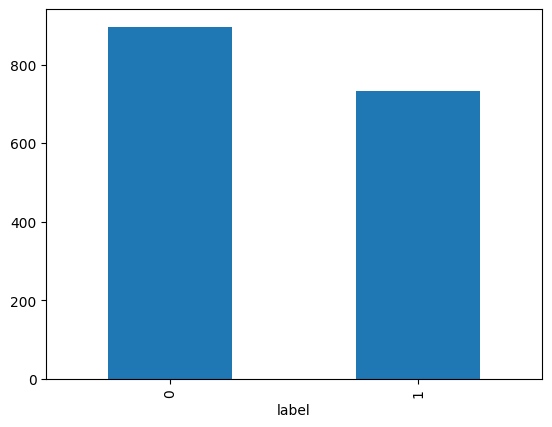

In [14]:
train.value_counts('label').plot(kind='bar')

## Export full df, train, val and test for future use

In [16]:
df.to_csv('../assets/data/df.csv', index=False)
train.to_csv('../assets/data/splits/train/raw.csv', index=False)
val.to_csv('../assets/data/splits/val/raw.csv', index=False)
test.to_csv('../assets/data/splits/test/raw.csv', index=False)